In [32]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [3]:
from mejiro.lenses import lens_util

detectable_lenses = lens_util.get_detectable_lenses(config.machine.pipeline_dir, limit=1000, with_subhalos=True)
print(f'Number of detectable lenses: {len(detectable_lenses)}')

best_snr = [l for l in detectable_lenses if l.snr > 50]
print(f'Number of high SNR lenses: {len(best_snr)}')

100%|██████████| 1000/1000 [00:20<00:00, 49.56it/s]

Number of detectable lenses: 1000
Number of high SNR lenses: 117


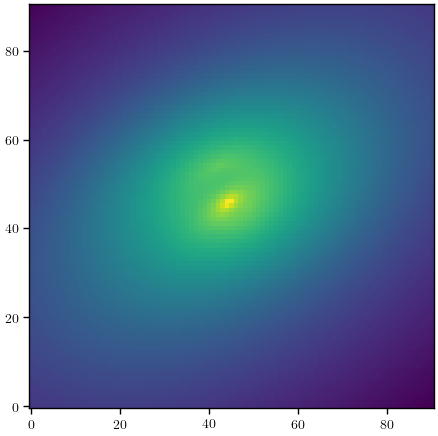

In [69]:
sample_lens = np.random.choice(best_snr)

num_pix = 91
side = 10.01

# generate synthetic image (surface brightness)
sb = sample_lens.get_array(num_pix=num_pix, side=side, band='F129')

plot.plot(np.log10(sb))

In [70]:
realization = sample_lens.realization
print(f'{len(realization.halos)} halo(s), max halo mass is {np.max([h.mass for h in realization.halos]):.0f}')

from pyHalo.Cosmology.cosmology import Cosmology
Cosmology(astropy_instance=sample_lens.cosmo)
halo_lens_model_list, halo_redshift_array, kwargs_halos, _ = realization.lensing_quantities(add_mass_sheet_correction=True)

532 halo(s), max halo mass is 589741694


In [71]:
halo_redshift_list = list(halo_redshift_array)

lens_model_total = LensModel(lens_model_list=sample_lens.lens_model_list_macro + halo_lens_model_list,
                        z_lens=sample_lens.z_lens,
                        z_source=sample_lens.z_source,
                        lens_redshift_list=sample_lens.redshift_list_macro + halo_redshift_list,
                        cosmo=sample_lens.cosmo,
                        multi_plane=False)

kwargs_lens_total = sample_lens.kwargs_lens_macro + kwargs_halos

In [72]:
_r = np.linspace(-side / 2, side / 2, num_pix)
xx, yy = np.meshgrid(_r, _r)
shape = xx.shape

alpha_x, alpha_y = lens_model_total.alpha(xx.ravel(), yy.ravel(), kwargs_lens_total)

print(alpha_x.reshape(num_pix, num_pix).shape)
print(alpha_y.reshape(num_pix, num_pix).shape)

(91, 91)
(91, 91)


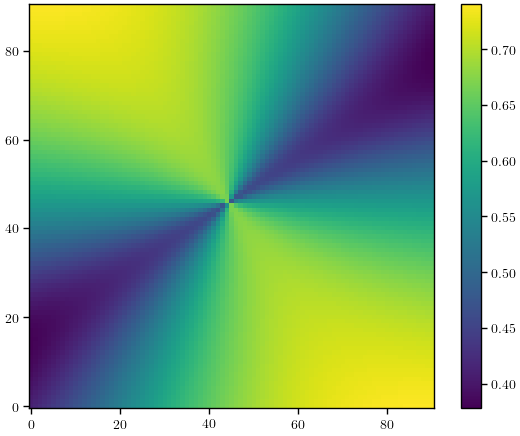

In [73]:
plt.imshow(np.sqrt(alpha_x.reshape(num_pix, num_pix)**2 + alpha_y.reshape(num_pix, num_pix)**2))
plt.colorbar()
plt.show()

In [74]:
pprint(halo_lens_model_list[-1])

'CONVERGENCE'


In [75]:
pprint(kwargs_halos[-1])

{'dec_0': 0.0, 'kappa': -0.011809074557206619, 'ra_0': 0.0}


In [76]:
total_kappa = sample_lens.get_total_kappa(num_pix=num_pix, side=side)
macrolens_kappa = sample_lens.get_macrolens_kappa(num_pix=num_pix, side=side)
subhalo_kappa = sample_lens.get_subhalo_kappa(num_pix=num_pix, side=side)

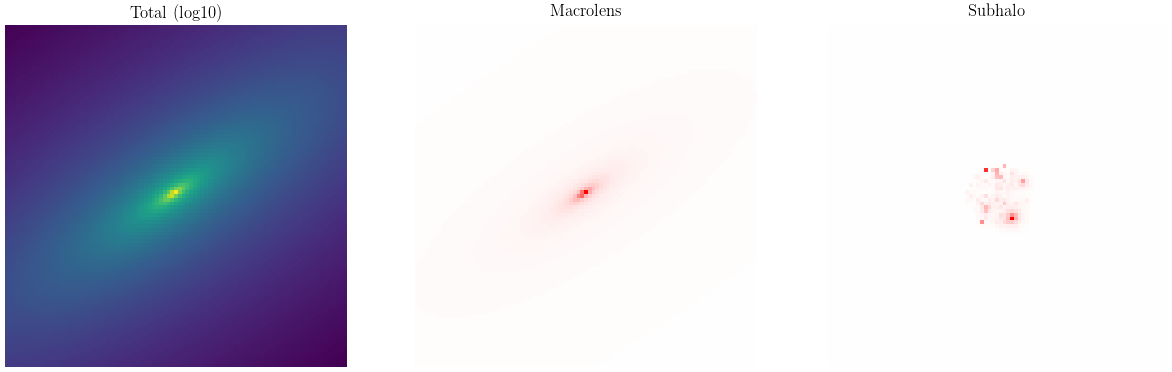

In [77]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(total_kappa))
ax[1].imshow(macrolens_kappa, cmap='bwr', vmin=-np.max(macrolens_kappa), vmax=np.max(macrolens_kappa))
ax[2].imshow(subhalo_kappa, cmap='bwr', vmin=-np.max(subhalo_kappa), vmax=np.max(subhalo_kappa))
ax[0].set_title('Total (log10)')
ax[1].set_title('Macrolens')
ax[2].set_title('Subhalo')
for a in ax: a.axis('off')
plt.show()

In [78]:
lens_cosmo = sample_lens.lens_cosmo

total_proj_mass = lens_cosmo.kappa2proj_mass(total_kappa)
macrolens_proj_mass = lens_cosmo.kappa2proj_mass(macrolens_kappa)
subhalo_proj_mass = lens_cosmo.kappa2proj_mass(subhalo_kappa)

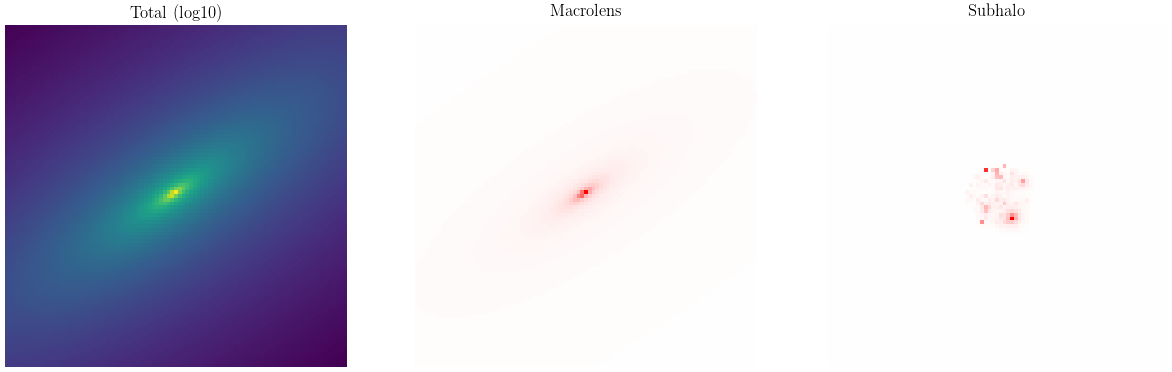

In [79]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(total_proj_mass))
ax[1].imshow(macrolens_proj_mass, cmap='bwr', vmin=-np.max(macrolens_proj_mass), vmax=np.max(macrolens_proj_mass))
ax[2].imshow(subhalo_proj_mass, cmap='bwr', vmin=-np.max(subhalo_proj_mass), vmax=np.max(subhalo_proj_mass))
ax[0].set_title('Total (log10)')
ax[1].set_title('Macrolens')
ax[2].set_title('Subhalo')
for a in ax: a.axis('off')
plt.show()

Check that the negative mass sheet is correctly subtracting the effect of subhalos

In [80]:
pprint(sample_lens.kwargs_lens[-1])

negative_mass_sheet = sample_lens.kwargs_lens[-1]['kappa']

{'dec_0': 0.0, 'kappa': -0.011809074557206619, 'ra_0': 0.0}


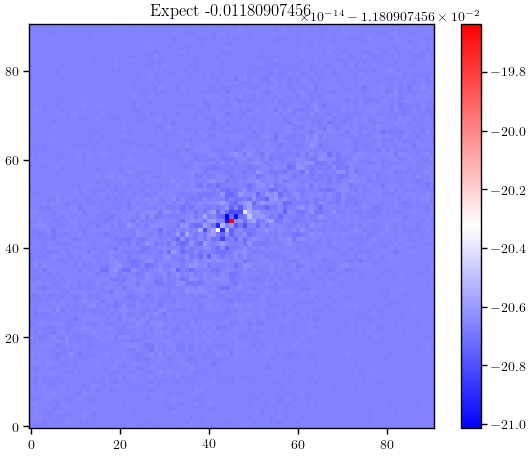

In [81]:
residuals = total_kappa - (macrolens_kappa + subhalo_kappa)

plt.imshow(residuals, cmap='bwr')
plt.colorbar()
plt.title(f'Expect {negative_mass_sheet:.11f}')
plt.show()

So yes, it is. The average lines up exactly with the kappa in the kwargs_lens. The deviations are order 1e-15 which can be chalked up to floating point error

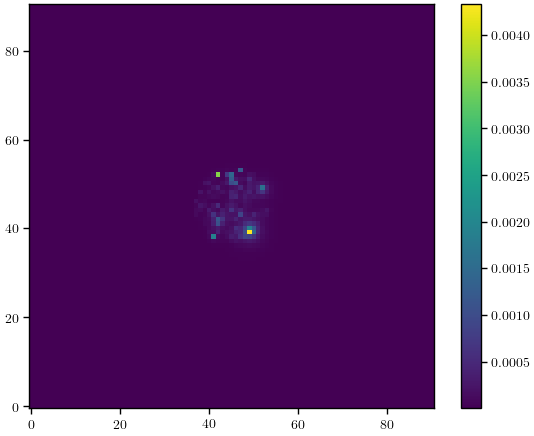

In [82]:
plt.imshow(subhalo_kappa)
plt.colorbar()
plt.show()

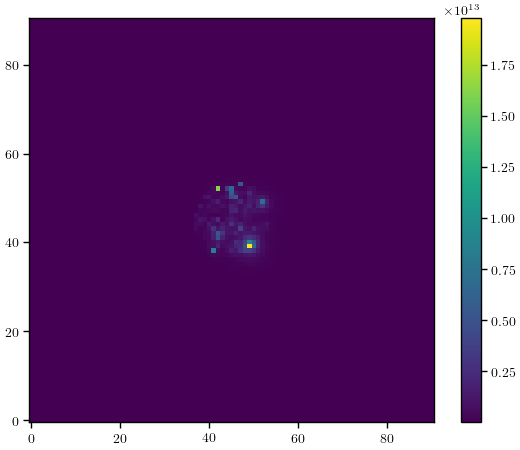

In [83]:
plt.imshow(subhalo_proj_mass)
plt.colorbar()
plt.show()